In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import fftpack

In [2]:
# matplotlib parameters 
large = 40; med = 20; small = 20
params = {'axes.titlesize': med,'axes.titlepad' : med,
          'legend.fontsize': med,'axes.labelsize': med ,
          'axes.titlesize': med ,'xtick.labelsize': med ,
          'ytick.labelsize': med ,'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]          
#plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)

# GP solver

In [3]:
PI = np.pi
H_BAR = 1.0545718 * 10 ** (-34)

class GrossPitaevskiiSolver:
    def __init__(self, time_step, tmax, position_arr, potential_func, number_of_atoms, initial_wavefunction):
        self.h_bar = 1.0545718 * 10 ** (-34)
        self.trap_frequency = 2 * np.pi * 70  # Hz
        self.number_of_atoms = number_of_atoms
        self.atom_mass = 1.4192261 * 10 ** (-25)  # kg
        self.a_s = 98.006 * 5.29 * 10 ** (-11)  # m
        self.a_0 = np.sqrt(self.h_bar / (self.trap_frequency * self.atom_mass))
        self.g = 4 * np.pi * self.h_bar ** 2 * self.a_s / (np.pi * self.a_0 ** 2 * self.atom_mass)
        
        if 4 * np.pi * self.a_s * self.number_of_atoms < self.a_0:
            raise ValueError(f"4*np.pi*a_s*number_of_atoms ({4 * np.pi * self.a_s * self.number_of_atoms}) must be greater than a_0 ({self.a_0}).")

        number_density = self.number_of_atoms / (np.pi * self.a_0 ** 2 * (np.ptp(position_arr)))
        if number_density * self.a_s ** 3 > 1:
            raise ValueError(f"Gross-Pitaevskii equation is valid if: {number_density * self.a_s ** 3} << 1")

        self.time_step = time_step
        self.tmax = tmax
        self.position_arr = position_arr
        self.potential_func = potential_func

        self.N = len(self.position_arr)
        self.dx = np.ptp(self.position_arr) / self.N

        self.x_s = (4 * np.pi * self.a_s * self.number_of_atoms * self.a_0 ** 4) ** (1 / 5)
        self.epsilon = (self.a_0 / self.x_s) ** 2
        self.delta = (self.g * self.number_of_atoms * (self.x_s ** 2)) / (self.a_0 ** 3 * self.h_bar * self.trap_frequency)

        self.position_arr_dimless = self.position_arr / self.x_s
        self.dx_dimless = self.dx / self.x_s
        self.L_dimless = np.ptp(self.position_arr_dimless)
        self.dk_dimless = (2 * np.pi) / self.L_dimless
        self.time_step_dimless = self.time_step * self.trap_frequency
        self.tmax_dimless = self.tmax * self.trap_frequency

        def normalize(psi_x_dimless):
            return psi_x_dimless / np.sqrt(np.sum(np.abs(psi_x_dimless) ** 2) * self.dx_dimless)
            
        if initial_wavefunction is None:
            print("Initial wavefunction is not provided. Using a Gaussian wavefunction as the initial wavefunction.")
            amplitude = 1.0
            mean = np.mean(self.position_arr_dimless)
            std_dev = 0.1
            psi_initial_dimless = amplitude * np.exp(-(self.position_arr_dimless - mean) ** 2 / (2 * std_dev ** 2)) * np.sqrt(self.x_s)
            self.psi_x_dimless = normalize(psi_initial_dimless)
        else:
            # The wavefunction must have dimensions of [1/length]^(1/2).
            initial_wavefunction_dimless = initial_wavefunction * np.sqrt(self.x_s)
            self.psi_x_dimless = normalize(initial_wavefunction_dimless)
            print("Normalization of the initial wavefunction = ", np.sum(np.abs(self.psi_x_dimless) ** 2) * self.dx_dimless)

    def hamiltonian_x_dimless(self, potential_func, psi_x_dimless):
        return potential_func / (self.epsilon * self.atom_mass * self.trap_frequency ** 2 * self.x_s ** 2) + self.delta * self.epsilon ** (3 / 2) * np.abs(psi_x_dimless) ** 2

    def kinetic_energy_dimless(self):
        k_dimless = np.hstack([np.arange(0, self.N / 2), np.arange(-self.N / 2, 0)]) * self.dk_dimless
        if len(k_dimless) != self.N:
            k_dimless = np.hstack([np.arange(0, self.N / 2), np.arange(-self.N / 2 + 1, 0)]) * self.dk_dimless
        return k_dimless ** 2 * self.epsilon / 2

    def solve(self, snapshots_lst):

        total_iterations = int(np.abs(self.tmax_dimless) / np.abs(self.time_step_dimless))
        print('Total iterations: ', total_iterations)

        def normalize(psi_x_dimless):
            return psi_x_dimless / np.sqrt(np.sum(np.abs(psi_x_dimless) ** 2) * self.dx_dimless)

        fixed_position_in_source_well = -4*1.e-6 # In micrometers unit.
        fixed_position_in_gate_well = 3.0*1.e-6 # In micrometers unit.
        fixed_position_in_drain_well = 15*1.e-6 # In micrometers unit.

        transistor_position_arr = self.position_arr
        if snapshots_lst:
            index_of_fixed_point_source_well = np.where(np.abs(transistor_position_arr - fixed_position_in_source_well) < 1.e-7)[0][0]
            index_of_fixed_point_gate_well = np.where(np.abs(transistor_position_arr - fixed_position_in_gate_well) < 1.e-7)[0][0]
            index_of_fixed_point_drain_well = np.where(np.abs(transistor_position_arr - fixed_position_in_drain_well) < 1.e-7)[0][0]

            wavefunction_at_fixed_point_source_arr = []
            wavefunction_at_fixed_point_gate_arr = []
            wavefunction_at_fixed_point_drain_arr = []    
            time_lst_to_save = []

        if snapshots_lst:
            snapshot_index = 0
            time = snapshots_lst[snapshot_index]  # Starting time.
            
        for iteration in range(total_iterations):

            self.psi_x_dimless = np.exp(-self.hamiltonian_x_dimless(self.potential_func, self.psi_x_dimless) * 1j * self.time_step_dimless / 2) * self.psi_x_dimless
            self.psi_x_dimless = normalize(self.psi_x_dimless)
            psi_k_dimless = fftpack.fft(self.psi_x_dimless)
            psi_k_dimless = np.exp(-(self.kinetic_energy_dimless() * 1j * self.time_step_dimless)) * psi_k_dimless

            self.psi_x_dimless = fftpack.ifft(psi_k_dimless)
            self.psi_x_dimless = normalize(self.psi_x_dimless)
            self.psi_x_dimless = np.exp(-self.hamiltonian_x_dimless(self.potential_func, self.psi_x_dimless) * 1j * self.time_step_dimless / 2) * self.psi_x_dimless
            self.psi_x_dimless = normalize(self.psi_x_dimless)

            if snapshots_lst:
                
                if np.isclose(time, snapshots_lst[snapshot_index]):
                    print(f"Saved snapshot at {time*1e3:.3f} ms")
                    snapshot_index += 1

                    time_evolved_wavefunction_time_split_dimless = self.psi_x_dimless                                            

                    path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
                    os.chdir(path)
                    np.save(f"wavefunction_time_evolved_{time*1e3:.3f}ms.npy", time_evolved_wavefunction_time_split_dimless)
                    # wavefunction_at_fixed_point_source_arr.append(time_evolved_wavefunction_time_split_dimless[index_of_fixed_point_source_well])
                    # wavefunction_at_fixed_point_gate_arr.append(time_evolved_wavefunction_time_split_dimless[index_of_fixed_point_gate_well])
                    # wavefunction_at_fixed_point_drain_arr.append(time_evolved_wavefunction_time_split_dimless[index_of_fixed_point_drain_well])  

                    if snapshot_index >= len(snapshots_lst):
                        break             
                           
                time += self.time_step  

        print("Normalization of the final wavefunction: ", np.sum(np.abs(self.psi_x_dimless) ** 2) * self.dx_dimless)
        print("Number of atoms in the trap = ", (self.number_of_atoms)*np.sum(np.abs(self.psi_x_dimless) ** 2) * self.dx_dimless)
        # if snapshots_lst:
        #     np.save("wavefunction_at_fixed_point_source_arr.npy",wavefunction_at_fixed_point_source_arr) 
        #     np.save("wavefunction_at_fixed_point_gate_arr.npy",wavefunction_at_fixed_point_gate_arr)
        #     np.save("wavefunction_at_fixed_point_drain_arr.npy",wavefunction_at_fixed_point_drain_arr)
        return normalize(self.psi_x_dimless)
            
    def number_of_atoms_interval(self, psi_time_evolved, a, b):

        def normalize(psi_x_dimless):
                return psi_x_dimless / np.sqrt(np.sum(np.abs(psi_x_dimless) ** 2) * self.dx_dimless)
                
        psi_time_evolved = normalize(psi_time_evolved)
        a_dimless = a / self.x_s
        b_dimless = b / self.x_s
        psi_from_a_to_b_dimless = psi_time_evolved[np.logical_and(self.position_arr_dimless >= a_dimless, self.position_arr_dimless <= b_dimless)]
        return (self.number_of_atoms)*np.sum(np.abs(psi_from_a_to_b_dimless)**2)*self.dx_dimless

# Setting up the triple well potential landscape

In [4]:
# Number of points in the grid.
N = 2**14

V_infinity  = 1.e4 # In kHz units.

# Position parameters in micrometers.
position_start      = -60
source_well_start   = -50
gate_well_start     = 0
gate_well_end       = 4.8
drain_well_end      = 480
position_end        = 500

path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
os.chdir(path)
np.save("position_start.npy",position_start)
np.save("position_end.npy",position_end)
np.save("source_well_start.npy",source_well_start)
np.save("gate_well_start.npy",gate_well_start)
np.save("gate_well_end.npy",gate_well_end)
np.save("drain_well_end.npy",drain_well_end)

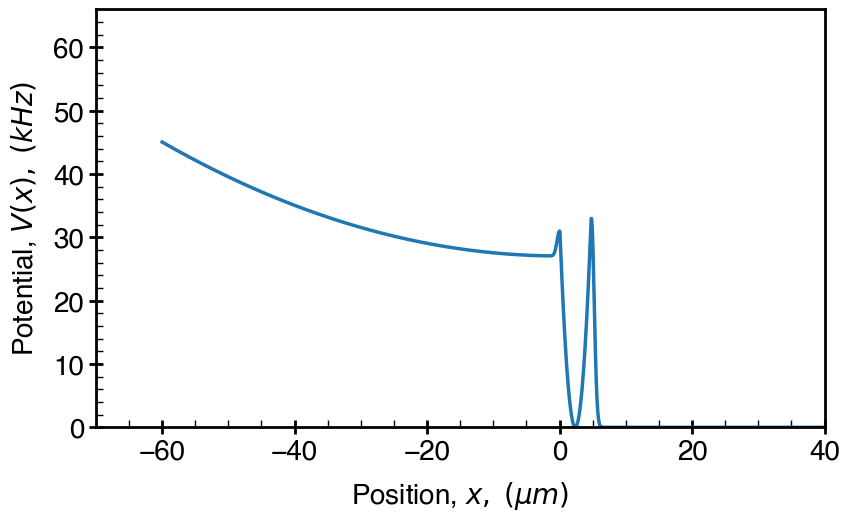

In [5]:
def left_tanh_function(xs, barrier_height, x_0, smoothness_control_parameter):
     """
     This function creates a smooth potential barrier with zero potential on the right of a given position x_0.

     Parameters
     ----------
          xs : array 
               The x-axis values.
          barrier_height : float
                The height of the barrier.
          x_0 : float 
               The position of the barrier.
          smoothness_control_parameter : float 
               The smoothness of the barrier. 

     Returns
     -------
          array
               The potential barrier.

     """     
     return barrier_height/2 - barrier_height/2 * np.tanh((xs-x_0)/(barrier_height*smoothness_control_parameter))

def right_tanh_function(xs, barrier_height, x_0, smoothness_control_parameter):
     """
     This function creates a smooth potential barrier with zero potential on the left of a given position x_0.

     Parameters
     ----------
          xs : array
               The x-axis values.
          barrier_height : float
                The height of the barrier.
          x_0 : float
               The position of the barrier.
          smoothness_control_parameter : float
               The smoothness of the barrier.
               
     Returns
     -------
          array
               The potential barrier

     """
     return barrier_height/2 + barrier_height/2 * np.tanh((xs-x_0)/(smoothness_control_parameter))

def different_plataeu_gaussian_barrier(x, x_0, barrier_height, left_plataeu_height, right_plataeu_height, sigma_1, sigma_2):
     """

     This function creates a Gaussian barrier centered at x_0 with a given barrier height with two different potential plateaus on the left and right of the barrier.

     Parameters
     ----------
          x : array
               The x-axis values.  
          x_0 : float
               The position of the barrier.
          barrier_height : float
               The height of the barrier.
          left_plataeu_height : float
               The height of the left plateau.
          right_plataeu_height : float
               The height of the right plateau.
          sigma_1 : float
               The width of the Gaussian barrier.
          sigma_2 : float
               The width of the tanh function.

     Returns
     -------
          array
               The potential barrier.
               
     """     
     return (barrier_height)*np.exp(-((x-x_0)/sigma_1)**2) + (left_plataeu_height + right_plataeu_height)/2 - (left_plataeu_height - right_plataeu_height)/2 * np.tanh((x-x_0)/(sigma_2))     


def source_well_potential_function(x, A, B, C, bias_potential_in_source_well):
     """ 
     This function creates a source well potential with a Gaussian barrier.

     Parameters
     ----------
          x : array
               The x-axis values.
          A : float
               Controls the width of the source well.
          B : float
               Controls the width of the SG barrier.
          C : float
               Controls the height of the SG barrier.
          bias_potential_in_source_well : float
               The bias potential in the source well.

     Returns
     -------
          array
               The source well potential.
     
     """
     return A*x**2+C*np.exp(-x**2/B)+bias_potential_in_source_well     

def harmonic_well(x1,y1,x2,y2,x3,y3):

     """
     This function returns the coefficients of a harmonic well equation given three points on the well.

     Parameters
     ----------
          x1 : float
               x-coordinate of the first point.
          y1 : float
               y-coordinate of the first point.
          x2 : float
               x-coordinate of the second point.
          y2 : float
               y-coordinate of the second point.
          x3 : float
               x-coordinate of the third point.
          y3 : float
               y-coordinate of the third point.

     Returns
     -------
          (float, float, float)
               The coefficients of the harmonic well equation. The harmonic well
               equation is given by c1*x**2 + c2*x + c3.
     """
     A = np.array([[x1**2, x1, 1],
                   [x2**2, x2, 1],
                   [x3**2, x3, 1]])
     b = np.array([y1, y2, y3])
     c1, c2, c3 = np.linalg.solve(A, b)
     return c1, c2, c3     

def transistor_potential_landscape(V_SS,  position_arr, SG_barrier_height, GD_barrier_height, gate_bias_potential,
     SIGMA_1 = 0.6,
     SIGMA_2 = 0.8,
     SIGMA_3 = 0.6,
     SIGMA_4 = 0.6,
     ):

     """
     This function creates a potential landscape for a transistor with a source well, gate well, and a drain well.

     Parameters
     ----------
          V_SS : float
               The bias potential in the source well.
          position_arr : array
               The x-axis values.
          SG_barrier_height : float
               The height of the SG barrier.
          GD_barrier_height : float
               The height of the GD barrier.
          gate_bias_potential : float
               The bias potential in the gate well.
          SIGMA_1 : float
               The width of the Gaussian barrier.
          SIGMA_2 : float
               The width of the tanh function.
          SIGMA_3 : float
               The width of the Gaussian barrier.
          SIGMA_4 : float
               The width of the tanh function.

     Returns
     -------
          array

     """

     # These are two offsets that makes the top of the V_SG and V_GD barriers smooth.
     delta_left = 0.05
     delta_right = 0.05

     # Creating the source well.
     A = 0.005 # Increasing A results in increase in width of the source well.
     B = 0.3 # Increasing B results in increase in width of the SG barrier.
     potential = np.zeros(len(position_arr))
     potential = np.where(position_arr <= gate_well_start + delta_left, source_well_potential_function(position_arr, A,B, SG_barrier_height - V_SS,V_SS), potential)

     # Creating the gate well.
     ## First point on the left side of the gate well.
     x_1 = gate_well_start + delta_left
     y_1 = source_well_potential_function(x_1, A, B, SG_barrier_height - V_SS, V_SS)

     ## Second point at the end of the gate well.
     x_2 = gate_well_end - delta_right
     y_2 = different_plataeu_gaussian_barrier(gate_well_end - delta_right, gate_well_end, GD_barrier_height, 0,0, SIGMA_3, SIGMA_4)

     ## Third point at the center of the gate well.
     x_3 = (gate_well_start + gate_well_end)/2
     y_3 = gate_bias_potential

     """ Harmonic gate well. """
     pp, qq, rr = harmonic_well(x_1, y_1, x_2, y_2, x_3, y_3)

     def harmonic_gate_well(x, pp, qq, rr):
          return pp*x**2 + qq*x + rr

     ## This loop creates the harmonic well in the gate well region and the GD barrier.
     for i in range(len(position_arr)):
          if position_arr[i] > gate_well_start + delta_left and position_arr[i] <= gate_well_end - delta_right:
               potential[i] = harmonic_gate_well(position_arr[i], pp, qq, rr)
               #potential[i] = anharmonic_gate_well(position_arr[i], pp, qq, rr, ss, tt)
          elif position_arr[i] >= gate_well_end - delta_right:
               potential[i] = different_plataeu_gaussian_barrier(position_arr, gate_well_end, GD_barrier_height, 0,0, SIGMA_3, SIGMA_4)[i]

     # Creates a barrier at the end of the drain well.
     potential = np.where(position_arr > (gate_well_end+drain_well_end)/2, right_tanh_function(position_arr, V_infinity, drain_well_end, 0.5), potential)

     return potential # In kHz units.   

# Position array in SI units (meters).
position_arr = np.linspace(position_start,position_end,N)*1.e-6
np.save("transistor_position_arr.npy", position_arr)

barrier_height_SG = 31 # In kHz units.
barrier_height_GD = 33 # In kHz units.

np.save("barrier_height_SG.npy", barrier_height_SG)
np.save("barrier_height_GD.npy", barrier_height_GD)

source_bias = 27.0625 # In kHz units.

complete_transistor_potential = transistor_potential_landscape(source_bias, position_arr*1.e6, barrier_height_SG, barrier_height_GD, 0.0)*10**3*H_BAR*2*PI # In SI units.
fig, axs = plt.subplots()
fig.set_figwidth(8.6)
fig.set_figheight(8.6/1.618)
plt.plot(position_arr*1.e6, complete_transistor_potential/(10**3*H_BAR*2*PI), linewidth = 2.5, color = "tab:blue")
plt.xlim([-70, 40])
plt.ylim([0, barrier_height_GD*2]) # In kHz units.
plt.ylabel(r"Potential, $V(x),\; (kHz)$",labelpad=10)
plt.xlabel(r"Position, $x, \; (\mu m)$",labelpad=10)
fig.tight_layout(pad=1.0)
for spine in axs.spines.values():
    spine.set_linewidth(2)
axs.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
axs.tick_params(axis="y", direction="inout", length=10, width=2, color="k")
axs.xaxis.set_minor_locator(ticker.AutoMinorLocator())
axs.yaxis.set_minor_locator(ticker.AutoMinorLocator())
axs.tick_params(which="minor", length=5, width=1, direction='in')
fig.tight_layout()    
# path = "/Users/sasankadowarah/atomtronics/cluster-codes/harmonic_gate_well"
# os.chdir(path)
# np.save("transistor_position_gaussian.npy",  xs_SI)
# np.save("transistor_potential_gaussian.npy", complete_transistor_potential_SI)
#plt.savefig("complete_transistor_potential_harmonic_gate_well.pdf", dpi=600)
plt.show()      

# Source well

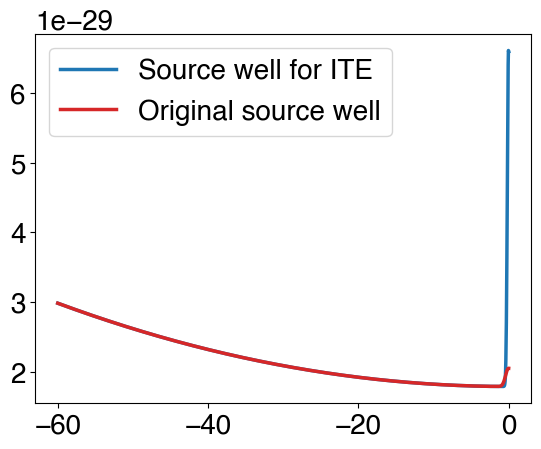

In [6]:
dx = np.ptp(position_arr)/N
source_well_position = np.arange(position_start*1.e-6, (gate_well_start + 0.05)*1.e-6, dx)*1.e6
A = 0.005 # Increasing A results in increase in left side of the source well.
B = 0.05 # Increasing B results in increase in width of the source well.
initial_SG_barrier_height = 100
V_SS = source_bias
source_well_potential = source_well_potential_function(source_well_position, A, B, initial_SG_barrier_height - V_SS,V_SS)*10**3*H_BAR*2*PI  # In SI units.
plt.plot(source_well_position, source_well_potential, label = "Source well for ITE", color = "tab:blue", linewidth = 2.5)
#plt.scatter(source_well_position, source_well_potential, color = "tab:blue", s = 20)
plt.plot(source_well_position, complete_transistor_potential[:len(source_well_position)], label = "Original source well", color = "tab:red", linewidth = 2.5)
#plt.scatter(source_well_position, complete_transistor_potential[:len(source_well_position)], color = "tab:red", s = 20)
plt.legend()
plt.show()

# Initial ground state in the source well

In [7]:
number_of_atoms = 30000

In [8]:
time_step = -1j*10**(-6) # In seconds unit.
tmax = 1.e-1 # In seconds unit.
solver_source_well = GrossPitaevskiiSolver(time_step, tmax, source_well_position*1.e-6, source_well_potential, number_of_atoms, None)
psi_source_well_ITE_dimless = solver_source_well.solve([])

Initial wavefunction is not provided. Using a Gaussian wavefunction as the initial wavefunction.
Total iterations:  100000
Normalization of the final wavefunction:  1.0
Number of atoms in the trap =  30000.0


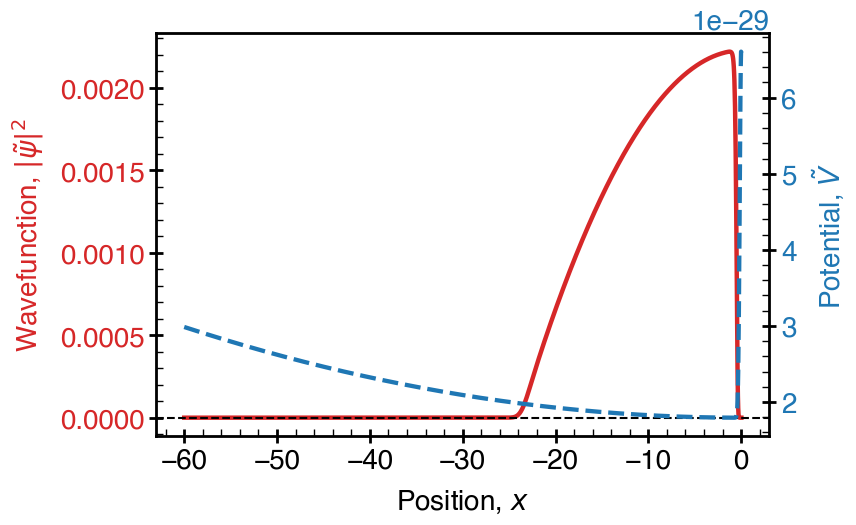

In [9]:
data0 = source_well_position
data1 = psi_source_well_ITE_dimless
data3 = source_well_potential

fig, ax1 = plt.subplots()

ax1.set_xlabel(r"Position, $x$", labelpad=10)
ax1.set_ylabel(r"Wavefunction, $|\tilde{\psi}|^{2}$", color="tab:red", labelpad=10)
ax1.plot(data0, np.abs(data1)**2*solver_source_well.dx_dimless, color="tab:red", linewidth=3.2)
ax1.tick_params(axis="y", labelcolor="tab:red")
ax2 = ax1.twinx()

color = "tab:blue"
ax2.set_ylabel(r"Potential, $\tilde{V}$ ", color=color, labelpad=10)
ax2.plot(data0, data3, color=color, linewidth=3.1, linestyle="--")
ax2.tick_params(axis="y", labelcolor=color)
ax1.axhline(y=0, color="k", linestyle='--')

fig.set_figwidth(8.6)
fig.set_figheight(8.6/1.618)
fig.tight_layout(pad=1.0)  # Adjust padding to ensure labels are not cut off

for spine in ax1.spines.values():
    spine.set_linewidth(2)
ax1.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
ax1.tick_params(axis="y", direction="inout", length=10, width=2, color="k")
ax2.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
ax2.tick_params(axis="y", direction="inout", length=10, width=2, color="k")

ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.tick_params(which="minor", length=5, width=1, direction='in')   

ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.tick_params(which="minor", length=5, width=1, direction='in')   
# Change the directory to save the PDF
# path = "/Users/sasankadowarah/atomtronics/cluster-codes/harmonic_gate_well"
# os.chdir(path)
# Save the figure
#plt.savefig("ground_state_in_source_well.pdf", dpi=600, bbox_inches='tight')

Chemical potential in the source well =  2.0911228657146927e-29 (J) or 29.900960311317185 (kHz)


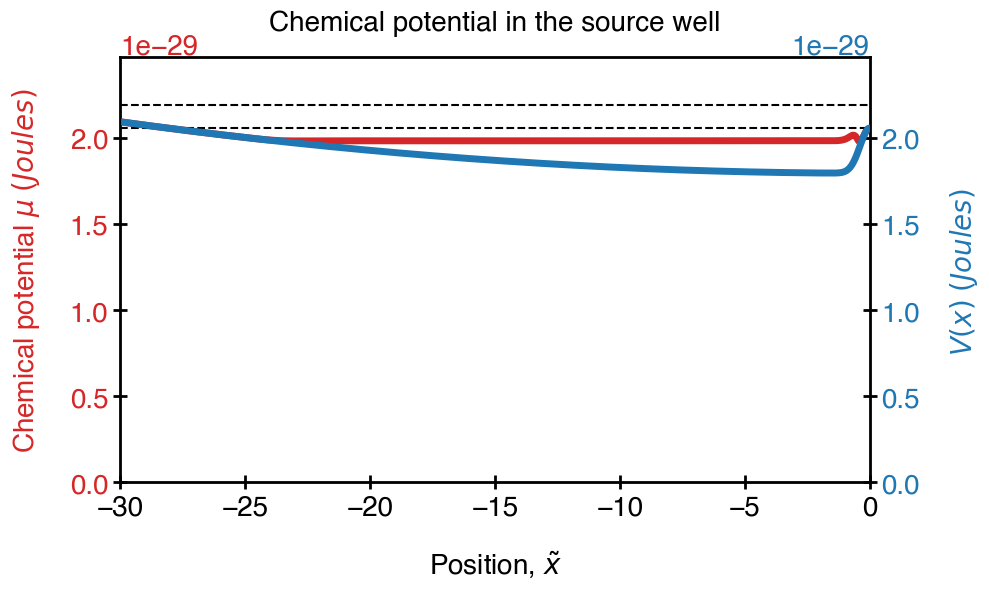

In [10]:
data0 = source_well_position
source_well_potential = complete_transistor_potential[0:len(source_well_position)]
data1 = source_well_potential + solver_source_well.g*number_of_atoms*np.abs(psi_source_well_ITE_dimless/np.sqrt(solver_source_well.x_s))**2
data3 = source_well_potential 

fig, ax1 = plt.subplots()

ax1.set_xlabel(r"Position, $\tilde{x}$", labelpad=20)
ax1.set_ylabel(r"Chemical potential $\mu\; (Joules)$", color="tab:red", labelpad=20)
ax1.plot(data0, data1, color="tab:red",linewidth = 5)
plt.title(r"Chemical potential in the source well")
#plt.legend()
ax1.tick_params(axis="y", labelcolor="tab:red")
ax2 = ax1.twinx()

color = "tab:blue"
ax2.set_ylabel(r"$V(x)\; (Joules)$ ", color=color,  labelpad=20)
ax2.plot(data0, data3, color=color,linewidth = 5)
ax2.tick_params(axis="y", labelcolor=color)
fig.set_figwidth(10)
fig.set_figheight(6)
plt.subplots_adjust(bottom=0.2)
for spine in ax1.spines.values():
    spine.set_linewidth(2)
ax1.set_xlim([-30,0])    
ax2.set_ylim([  0, barrier_height_SG * 10**3*H_BAR*2*PI*1.2 ])
ax1.set_ylim([0, barrier_height_SG*10**3*H_BAR*2*PI*1.2 ])
ax1.axhline(y = barrier_height_GD * 10**3*H_BAR*2*PI , color="k", linestyle='--')
ax1.axhline(y = barrier_height_SG * 10**3*H_BAR*2*PI , color="k", linestyle='--')
ax1.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
ax1.tick_params(axis="y", direction="inout", length=10, width=2, color="k")
ax2.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
ax2.tick_params(axis="y", direction="inout", length=10, width=2, color="k")
print("Chemical potential in the source well = ", data1[len(data1)//2],"(J) or",data1[int(len(data1)/1.1)]/(H_BAR*10**3*2*PI), "(kHz)")
#ax1.set_xlim([-4,0])
#plt.savefig("chemical_potential_in_source_well_16_1000_"+str(NUMBER_OF_ATOMS)+".jpg", dpi=600)
fig.tight_layout()

# Real time evolution

In [11]:
# Put the initial ground state in the source well of the transistor.
psi_initial_for_full_potential_dimless = psi_source_well_ITE_dimless
while len(psi_initial_for_full_potential_dimless) < len(position_arr):
    psi_initial_for_full_potential_dimless = np.hstack((psi_initial_for_full_potential_dimless, np.array([0])))

time_step = 10**(-7) # In seconds unit.
tmax = 40*1.e-3 # In seconds unit.

time_lst = list(np.arange(0.0,tmax,0.001*1.e-3))

solver_complete_potential = GrossPitaevskiiSolver(time_step, tmax, position_arr, complete_transistor_potential, number_of_atoms, psi_initial_for_full_potential_dimless)
#time_evolved_wavefunction_time_split = solver_complete_potential.solve(time_lst)

Normalization of the initial wavefunction =  0.9999999999999998


# FFT of the drain well wavefunction

In [12]:
# wavefunction_at_fixed_point_source_arr = np.load("wavefunction_at_fixed_point_source_arr.npy")
# wavefunction_at_fixed_point_gate_arr = np.load("wavefunction_at_fixed_point_gate_arr.npy")
# wavefunction_at_fixed_point_drain_arr = np.load("wavefunction_at_fixed_point_drain_arr.npy")

transistor_position_arr= np.load("transistor_position_arr.npy")

def find_index_of_fixed_position(array, fixed_position, atol=1e-7, rtol=1e-7):
    """Finds the index of the closest element in the array to the fixed position.

    Args:
        array: The array to search.
        fixed_position: The fixed position to find.
        atol: The absolute tolerance for the comparison.
        rtol: The relative tolerance for the comparison.

    Returns:
        The index of the closest element.

    Raises:
        ValueError: If the fixed position is not found within the tolerance.
    """
    indices = np.where(np.isclose(array, fixed_position, atol=atol, rtol=rtol))[0]
    if len(indices) == 0:
        raise ValueError("Fixed position not found within tolerance.")
    return indices[0]  # Return the first index if multiple matches are found

fixed_position_in_source_well = -16 * 1e-6  # In micrometers unit
fixed_position_in_gate_well = 4 * 1e-6  # In micrometers unit
fixed_position_in_drain_well = 30 * 1e-6  # In micrometers unit

index_of_fixed_point_source_well = find_index_of_fixed_position(transistor_position_arr, fixed_position_in_source_well)
index_of_fixed_point_gate_well = find_index_of_fixed_position(transistor_position_arr, fixed_position_in_gate_well)
index_of_fixed_point_drain_well = find_index_of_fixed_position(transistor_position_arr, fixed_position_in_drain_well)

wavefunction_at_fixed_point_source_arr = []
wavefunction_at_fixed_point_gate_arr = []
wavefunction_at_fixed_point_drain_arr = []

tmax_new = tmax - 1*1.e-3 # In seconds unit.
time_lst = list(np.arange(0.0,tmax_new,0.001*1.e-3))

for time in time_lst:
     print(f"Time = {time*1e3:.3f} ms")
     time_evolved_wavefunction_time_split_dimless = np.load(f"wavefunction_time_evolved_{time*1e3:.3f}ms.npy")
     wavefunction_at_fixed_point_source_arr.append(time_evolved_wavefunction_time_split_dimless[index_of_fixed_point_source_well])
     wavefunction_at_fixed_point_gate_arr.append(time_evolved_wavefunction_time_split_dimless[index_of_fixed_point_gate_well])
     wavefunction_at_fixed_point_drain_arr.append(time_evolved_wavefunction_time_split_dimless[index_of_fixed_point_drain_well]) 

Time = 0.000 ms
Time = 0.001 ms
Time = 0.002 ms
Time = 0.003 ms
Time = 0.004 ms
Time = 0.005 ms
Time = 0.006 ms
Time = 0.007 ms
Time = 0.008 ms
Time = 0.009 ms
Time = 0.010 ms
Time = 0.011 ms
Time = 0.012 ms
Time = 0.013 ms
Time = 0.014 ms
Time = 0.015 ms
Time = 0.016 ms
Time = 0.017 ms
Time = 0.018 ms
Time = 0.019 ms
Time = 0.020 ms
Time = 0.021 ms
Time = 0.022 ms
Time = 0.023 ms
Time = 0.024 ms
Time = 0.025 ms
Time = 0.026 ms
Time = 0.027 ms
Time = 0.028 ms
Time = 0.029 ms
Time = 0.030 ms
Time = 0.031 ms
Time = 0.032 ms
Time = 0.033 ms
Time = 0.034 ms
Time = 0.035 ms
Time = 0.036 ms
Time = 0.037 ms
Time = 0.038 ms
Time = 0.039 ms
Time = 0.040 ms
Time = 0.041 ms
Time = 0.042 ms
Time = 0.043 ms
Time = 0.044 ms
Time = 0.045 ms
Time = 0.046 ms
Time = 0.047 ms
Time = 0.048 ms
Time = 0.049 ms
Time = 0.050 ms
Time = 0.051 ms
Time = 0.052 ms
Time = 0.053 ms
Time = 0.054 ms
Time = 0.055 ms
Time = 0.056 ms
Time = 0.057 ms
Time = 0.058 ms
Time = 0.059 ms
Time = 0.060 ms
Time = 0.061 ms
Time = 0

In [13]:
40-25

15

In [14]:
# fig, ax1 = plt.subplots()
# fig.set_figwidth(20)
# fig.set_figheight(6)

density_source = np.abs(wavefunction_at_fixed_point_source_arr)**2 - np.mean(np.abs(wavefunction_at_fixed_point_source_arr)**2)
density_gate = np.abs(wavefunction_at_fixed_point_gate_arr)**2 - np.mean(np.abs(wavefunction_at_fixed_point_gate_arr)**2)
density_drain = np.abs(wavefunction_at_fixed_point_drain_arr)**2 - np.mean(np.abs(wavefunction_at_fixed_point_drain_arr)**2)

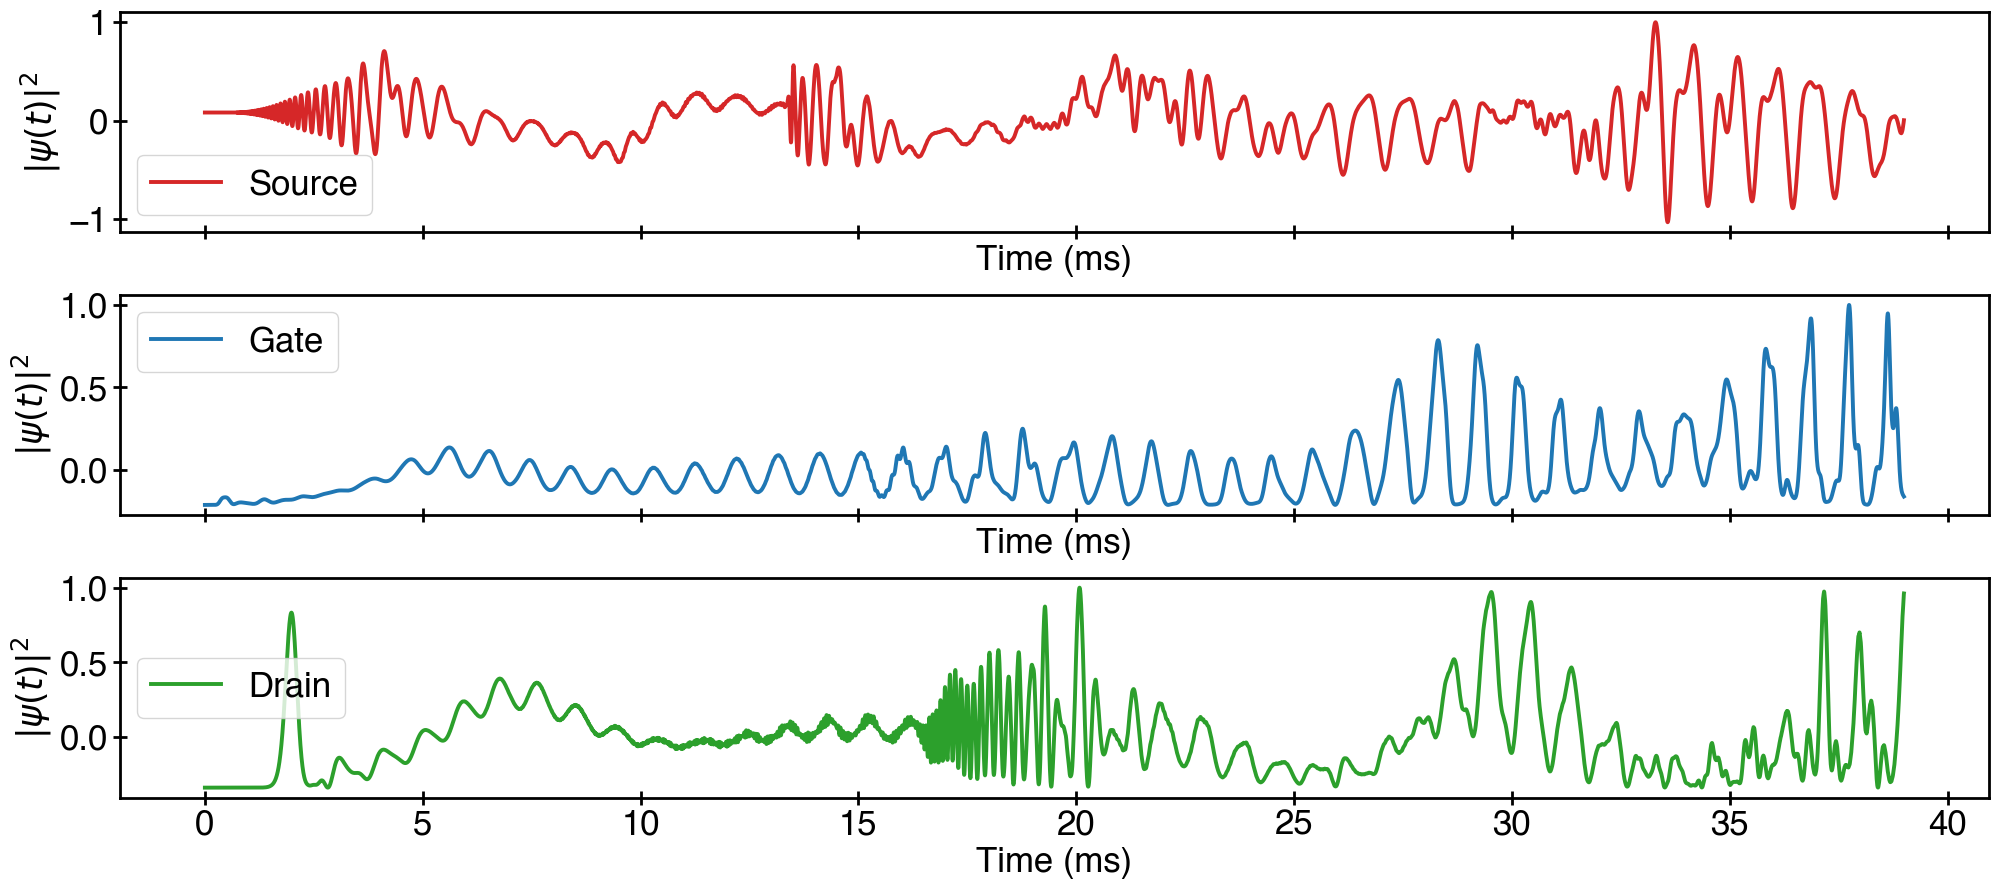

In [15]:
# matplotlib parameters 
large = 40; med = 25; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]          
#plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20, 9))

# Plotting each array in a separate subplot
axs[0].plot(np.array(time_lst)*1.e3,density_source/np.max(density_source), color="tab:red", linewidth = 2.8, label="Source")
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("$|\psi(t)|^{2}$")
#axs[0].set_title("Source Atom Number vs. Time")

axs[1].plot(np.array(time_lst)*1.e3, density_gate/np.max(density_gate) , color="tab:blue",linewidth = 2.8, label="Gate")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("$|\psi(t)|^{2}$")
#axs[1].set_title("Gate Atom Number vs. Time")

axs[2].plot(np.array(time_lst)*1.e3, density_drain/np.max(density_drain) , color="tab:green",linewidth = 2.8, label="Drain")
axs[2].set_xlabel("Time (ms)")
axs[2].set_ylabel("$|\psi(t)|^{2}$")
#axs[2].set_title("Drain Atom Number vs. Time")

# Adding a legend
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Plotting grid.
# axs[0].grid()
# axs[1].grid()
# axs[2].grid()


for spine in axs[0].spines.values():
    spine.set_linewidth(2)
for spine in axs[1].spines.values():
    spine.set_linewidth(2)   
for spine in axs[2].spines.values():
    spine.set_linewidth(2)   
for i in range(3):     
     axs[i].tick_params(axis="x", direction="inout", length=10, width=2, color="k")
     axs[i].tick_params(axis="y", direction="inout", length=10, width=2, color="k")
     axs[i].tick_params(axis="x", direction="inout", length=10, width=2, color="k")
     axs[i].tick_params(axis="y", direction="inout", length=10, width=2, color="k")
     # axs[i].xaxis.set_minor_locator(ticker.AutoMinorLocator())
     # axs[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())    
     # axs[i].tick_params(which="minor", length=5, width=1, direction='in')
     # axs[i].xaxis.set_minor_locator(ticker.AutoMinorLocator())
     # axs[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
     # axs[i].tick_params(which="minor", length=5, width=1, direction='in')  

# Customize x-axis tick labels
# interval = 10
# ticks = list(range(0, 21, interval))
# axs[2].set_xticks(ticks)
# axs[2].set_xticklabels([str(tick) for tick in ticks])
# Adjust layout to prevent overlap
plt.tight_layout()

# path ="/Users/sasankadowarah/atomtronics/cluster-codes/harmonic_gate_well"
# os.chdir(path)
# plt.savefig("wavefunction_density_at_fixed_z.pdf", dpi=600)

# Show the plot
plt.show()

In [25]:
PI = np.pi
H_BAR = 6.626*10**(-34)/(2*PI)
ATOM_MASS = 1.4192261*10**(-25) # kg
barrier_height_SG = 31 # kHz
barrier_height_GD = 33 # kHz
gate_well_start = np.load("gate_well_start.npy")
gate_well_end = np.load("gate_well_end.npy")
print("Gate well width = ", gate_well_end - gate_well_start,r"$\mu m$")
# Single particle energy levels in gate well.
single_particle_omega = np.sqrt(8*barrier_height_SG*10**3*H_BAR*2*PI/(ATOM_MASS*(gate_well_end*1.e-6 - gate_well_start*1.e-6)**2))
print(r"Single particle energy level frequency = ", single_particle_omega, "(rad/s)")
# Number of single particle energy levels in the gate well.
# n_levels = int((barrier_height_GD*10**3*H_BAR*2*PI)/(H_BAR*single_particle_omega) - 1/2)
# print("Number of single particle energy levels in the gate well = ", n_levels)

Gate well width =  4.8 $\mu m$
Single particle energy level frequency =  7088.9926183080615 (rad/s)


Dominant Frequencies and Powers:
Angular Frequency (rad/s): 805.54, Power: 6.78e+06
Angular Frequency (rad/s): 644.43, Power: 5.08e+06
Angular Frequency (rad/s): 483.32, Power: 3.93e+06
Angular Frequency (rad/s): 6605.40, Power: 3.78e+06
Angular Frequency (rad/s): 7410.94, Power: 2.23e+06
Angular Frequency (rad/s): 322.21, Power: 1.63e+06
Angular Frequency (rad/s): 161.11, Power: 1.47e+06
Angular Frequency (rad/s): 1127.75, Power: 9.05e+05
Angular Frequency (rad/s): 7572.04, Power: 9.01e+05
Angular Frequency (rad/s): 5960.97, Power: 8.89e+05


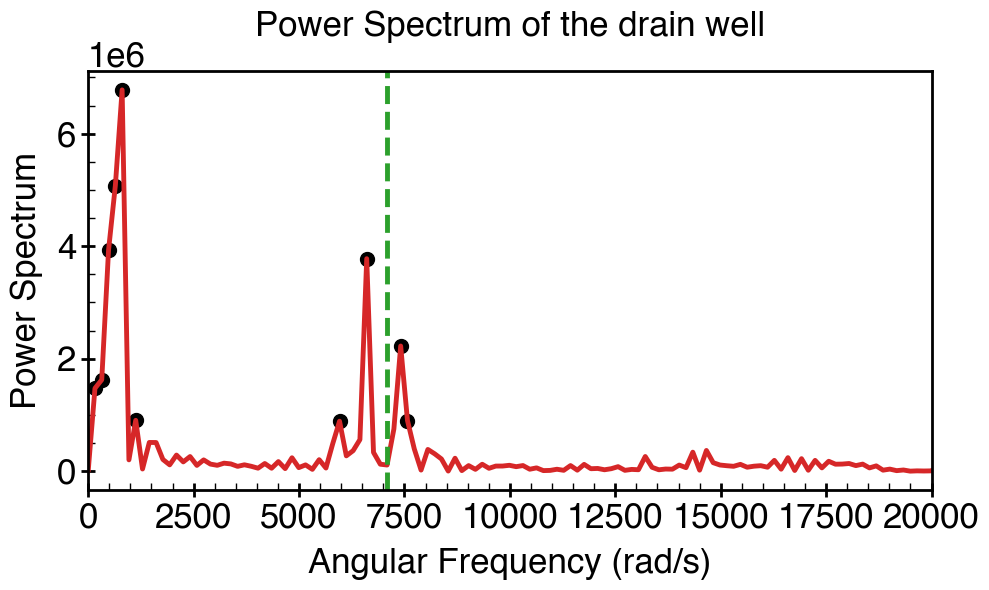

In [28]:
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]          
plt.rcParams.update(params)
from scipy.fft import fft, fftfreq, fftshift

dt = 0.001*1.e-3

#signal = density_source/np.max(density_source)
# signal = density_gate/ np.max(density_gate)
signal = density_drain / np.max(density_drain)

signal = signal - np.mean(signal)
n = len(signal)
fft_result = fft(signal)
frequencies = fftfreq(n, d=dt)  # Convert dt to seconds
fft_result_shifted = fftshift(fft_result)
frequencies_shifted = fftshift(frequencies)
power_spectrum = np.abs(fft_result_shifted) ** 2
peak_indices = np.argsort(-power_spectrum)[:20]  # Get top 5 peaks
dominant_frequencies = frequencies_shifted[peak_indices]
dominant_powers = power_spectrum[peak_indices]

fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)
plt.plot(2*np.pi*frequencies_shifted, power_spectrum, linewidth=3.5, color="tab:red")
plt.scatter(2*np.pi*frequencies_shifted[peak_indices], power_spectrum[peak_indices], color="k" , s=100, marker="o"  ,label="Dominant Frequencies")
plt.xlabel("Angular Frequency (rad/s)", labelpad=10)
plt.ylabel("Power Spectrum", labelpad=10)
plt.title("Power Spectrum of the drain well")
plt.xlim([0, 20000])
for spine in ax1.spines.values():
    spine.set_linewidth(2)
ax1.tick_params(axis="x", direction="inout", length=10, width=2, color="k")
ax1.tick_params(axis="y", direction="inout", length=10, width=2, color="k")
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())    
ax1.tick_params(which="minor", length=5, width=1, direction='in')
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.tick_params(which="minor", length=5, width=1, direction='in')
fig.tight_layout()
plt.axvline(x=single_particle_omega , color="tab:green", linestyle="--", linewidth=3.5)
#plt.axvline(x=2*single_particle_omega , color="tab:blue", linestyle="--", linewidth=3.5)
positive_dominant_freqs = dominant_frequencies[dominant_frequencies > 0]
positive_dominant_powers = dominant_powers[dominant_frequencies > 0]
omega_drain = 2 * np.pi * positive_dominant_freqs
print("Dominant Frequencies and Powers:")
for freq, power in zip(omega_drain, positive_dominant_powers):
    print(f"Angular Frequency (rad/s): {freq:.2f}, Power: {power:.2e}")

# path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
# os.chdir(path)
# plt.savefig("power_spectrum_drain_well_40.png", dpi=600)  
plt.show()  

# Atom Number as Function of Time

In [18]:
# """
# Given a time and index of the source bias potential the following
# function calculates the number of atoms in the source; gate and
# the drain well.

# """
# def source_atom_number(final_time):
#      path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
#      os.chdir(path)
#      wavefunction_dimless = np.load(f"wavefunction_time_evolved_{time*1e3:.3f}ms.npy")    
#      psi_lst_dimless = []
#      for i in range(N):
#           if source_well_start <= (position_arr*1.e6)[i] <= gate_well_start:
#                psi_lst_dimless.append(wavefunction_dimless[i])
#      return int(number_of_atoms*np.sum(np.abs(psi_lst_dimless)**2)*solver_complete_potential.dx_dimless)

# def gate_atom_number(final_time):
#      path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
#      os.chdir(path)
#      wavefunction_dimless = np.load(f"wavefunction_time_evolved_{time*1e3:.3f}ms.npy")    
#      psi_lst_dimless = []
#      for i in range(N):
#           if gate_well_start <= (position_arr*1.e6)[i] <= gate_well_end:
#                psi_lst_dimless.append(wavefunction_dimless[i])
#      return int(number_of_atoms*np.sum(np.abs(psi_lst_dimless)**2)*solver_complete_potential.dx_dimless)   

# def drain_atom_number(final_time):
#      path = "/Users/sasankadowarah/atomtronics/triple-well-transistor/data/"
#      os.chdir(path)
#      wavefunction_dimless = np.load(f"wavefunction_time_evolved_{time*1e3:.3f}ms.npy")    
#      psi_lst_dimless = []
#      for i in range(N):
#           if gate_well_end <= (position_arr*1.e6)[i] <= position_end:
#                psi_lst_dimless.append(wavefunction_dimless[i])
#      return int(number_of_atoms*np.sum(np.abs(psi_lst_dimless)**2)*solver_complete_potential.dx_dimless)

# time_lst = list(np.arange(0.0,tmax_new,0.1*1.e-3))

# source_atom_number_lst = []
# gate_atom_number_lst = []
# drain_atom_number_lst = []

# for time in time_lst:
#      source_atom_number_lst.append(source_atom_number(time))
#      gate_atom_number_lst.append(gate_atom_number(time))
#      drain_atom_number_lst.append(drain_atom_number(time))     

In [19]:
# # Create a figure and a set of subplots
# fig, axs = plt.subplots(3, 1, sharex=True, figsize=(20, 3*5))

# # Plotting each array in a separate subplot
# axs[0].plot(np.array(time_lst)*1.e3, source_atom_number_lst, color="tab:red", linewidth = 3.5, label="Source")
# #axs[0].scatter(time_lst, source_atom_number_lst, color="tab:red", s = 100)
# axs[0].set_xlabel("Time (ms)")
# axs[0].set_ylabel("Atom number")
# #axs[0].set_title("Source Atom Number vs. Time")

# axs[1].plot(np.array(time_lst)*1.e3, gate_atom_number_lst, color="tab:blue",linewidth = 3.5, label="Gate")
# #axs[1].scatter(time_lst, gate_atom_number_lst, color="tab:blue", s = 100)
# axs[1].set_xlabel("Time (ms)")
# axs[1].set_ylabel("Atom number")
# #axs[1].set_title("Gate Atom Number vs. Time")

# axs[2].plot(np.array(time_lst)*1.e3, drain_atom_number_lst, color="tab:green",linewidth = 3.5, label="Drain")
# #axs[2].scatter(time_lst, drain_atom_number_lst, color="tab:green", s = 100)
# axs[2].set_xlabel("Time (ms)")
# axs[2].set_ylabel("Atom number")
# #axs[2].set_title("Drain Atom Number vs. Time")

# # Adding a legend
# axs[0].legend()
# axs[1].legend()
# axs[2].legend()

# # Plotting grid.
# # axs[0].grid()
# # axs[1].grid()
# # axs[2].grid()


# for spine in axs[0].spines.values():
#     spine.set_linewidth(2)
# for spine in axs[1].spines.values():
#     spine.set_linewidth(2)   
# for spine in axs[2].spines.values():
#     spine.set_linewidth(2)   
# for i in range(3):     
#      axs[i].tick_params(axis="x", direction="inout", length=10, width=2, color="k")
#      axs[i].tick_params(axis="y", direction="inout", length=10, width=2, color="k")
#      axs[i].tick_params(axis="x", direction="inout", length=10, width=2, color="k")
#      axs[i].tick_params(axis="y", direction="inout", length=10, width=2, color="k")
#      # axs[i].xaxis.set_minor_locator(ticker.AutoMinorLocator())
#      # axs[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())    
#      # axs[i].tick_params(which="minor", length=5, width=1, direction='in')
#      # axs[i].xaxis.set_minor_locator(ticker.AutoMinorLocator())
#      # axs[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
#      # axs[i].tick_params(which="minor", length=5, width=1, direction='in')  

# # # Customize x-axis tick labels
# # interval = 10
# # ticks = list(range(0, 101, interval))
# # axs[2].set_xticks(ticks)
# # axs[2].set_xticklabels([str(tick) for tick in ticks])
# # Adjust layout to prevent overlap
# plt.tight_layout()

# # path ="/Users/sasankadowarah/atomtronics/triple-well-transistor/"
# # os.chdir(path)
# # plt.savefig("harmonic_gate_well_V_SS_"+str(source_bias)+".jpg", dpi=600)

# # Show the plot
# plt.show()

In [20]:
# wavefunction_at_fixed_point_source_arr = np.load("wavefunction_at_fixed_point_source_arr.npy")
# wavefunction_at_fixed_point_gate_arr = np.load("wavefunction_at_fixed_point_gate_arr.npy")
# wavefunction_at_fixed_point_drain_arr = np.load("wavefunction_at_fixed_point_drain_arr.npy")

# plt.plot(np.abs(wavefunction_at_fixed_point_source_arr)**2, color = "tab:red", label = "Source")